In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1eToBctRfz2b83KgP25xRsJ2mZAeqYtHB
!gdown https://drive.google.com/uc?id=1DL6Shq1GQtUvPCxJkPSBUQs9YzMlb15H
!unzip /kaggle/working/data_semantic_segmentation_baseline.zip
!pip install albumentations

zsh:1: no matches found: https://drive.google.com/uc?id=1eToBctRfz2b83KgP25xRsJ2mZAeqYtHB
zsh:1: no matches found: https://drive.google.com/uc?id=1DL6Shq1GQtUvPCxJkPSBUQs9YzMlb15H
unzip:  cannot find or open /kaggle/working/data_semantic_segmentation_baseline.zip, /kaggle/working/data_semantic_segmentation_baseline.zip.zip or /kaggle/working/data_semantic_segmentation_baseline.zip.ZIP.


In [3]:
!ls

README.md
create-custom-coco-dataset-crop.ipynb
create-custom-coco-dataset.ipynb
create-custom-coco-dataset_original.ipynb
data_semantic_segmentation_baseline
dataset
dataset_crop
env
model_file
notes.json
output
output_crop
requirements.txt
src
test_polygon1.ipynb
unet.ipynb


In [4]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
mask_id, image_ = [], []
mask_V, image_V = [], []
mask_T, image_T = [], []

def get_paths():
    for file in sorted(os.listdir('./data_semantic_segmentation_baseline/masks/train')):
        mask_id.append(os.path.join('./data_semantic_segmentation_baseline/masks/train', file))
    for file in sorted(os.listdir('./data_semantic_segmentation_baseline/imgs/train')):
        image_.append(os.path.join('./data_semantic_segmentation_baseline/imgs/train', file))
    for file in sorted(os.listdir('./data_semantic_segmentation_baseline/masks/validation')):
        mask_V.append(os.path.join('./data_semantic_segmentation_baseline/masks/validation', file))
    for file in sorted(os.listdir('./data_semantic_segmentation_baseline/imgs/validation')):
        image_V.append(os.path.join('./data_semantic_segmentation_baseline/imgs/validation', file))
    for file in sorted(os.listdir('./data_semantic_segmentation_baseline/masks/test')):
        mask_T.append(os.path.join('./data_semantic_segmentation_baseline/masks/test', file))
    for file in sorted(os.listdir('./data_semantic_segmentation_baseline/imgs/test')):
        image_T.append(os.path.join('./data_semantic_segmentation_baseline/imgs/test', file))

get_paths()

**Augment training images with transformations**

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from pylab import rcParams
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import random
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps, Image


image_transforms = Compose([
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
])
mask_transforms = Compose([
            Rotate(limit=90),
            HorizontalFlip()
])
def aug_fn(image, img_size, mask=False):
    data = {"image":image}
    if mask is False:
        aug_data = image_transforms(**data)
    else:
        aug_data = mask_transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img / 255, tf.float32)
    if mask is False:
        aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img
img_idx = 0
for i in range(1, len(image_)):
    img_path, mask_path = image_[i], mask_id[i]
    img_load = cv2.imread(img_path)
    mask_load = cv2.imread(mask_path, 0)
    transformed_img = np.asarray(aug_fn(np.asarray(img_load), 896))
    transformed_mask = np.asarray(aug_fn(np.asarray(mask_load), 896, mask=True))
    filename = './data_semantic_segmentation_baseline/imgs/train/augmented_img_' + str(img_idx) + '.png'
    cv2.imwrite(filename, transformed_img)
    filename = './data_semantic_segmentation_baseline/masks/train/augmented_mask_' + str(img_idx + 1) + '.png'
    cv2.imwrite(filename, transformed_mask)
    rotate_90_img = np.asarray(cv2.rotate(img_load, cv2.ROTATE_90_CLOCKWISE))
    rotate_90_mask = np.asarray(cv2.rotate(mask_load, cv2.ROTATE_90_CLOCKWISE))
    img = Image.fromarray(rotate_90_img)
    mask = Image.fromarray(rotate_90_mask)
    filename = 'augmented_img_' + str(img_idx + 2) +'.png'
    img.save('./data_semantic_segmentation_baseline/imgs/train/{0}'.format(filename), 'PNG')
    filename = 'augmented_mask_' + str(img_idx + 3) + '.png'
    mask.save('./data_semantic_segmentation_baseline/masks/train/{0}'.format(filename), 'PNG')
    rotate_180_img = np.asarray(cv2.rotate(img_load, cv2.ROTATE_180))
    rotate_180_mask = np.asarray(cv2.rotate(img_load, cv2.ROTATE_180))
    filename = 'augmented_img_' + str(img_idx + 4) + '.png'
    img.save('./data_semantic_segmentation_baseline/imgs/train/{0}'.format(filename), 'PNG')
    filename = 'augmented_mask_' + str(img_idx + 5) + '.png'
    mask.save('./data_semantic_segmentation_baseline/imgs/train/{0}'.format(filename), 'PNG')
    img_idx += 6

get_paths()

**Visualize image and it's corresponding mask**

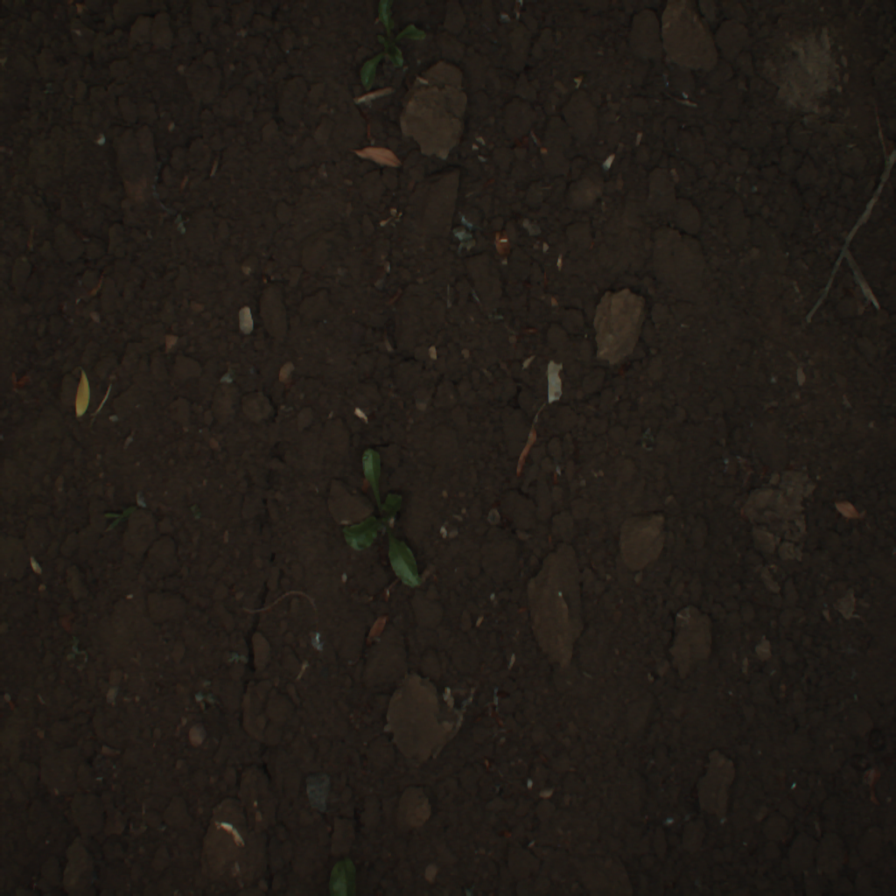

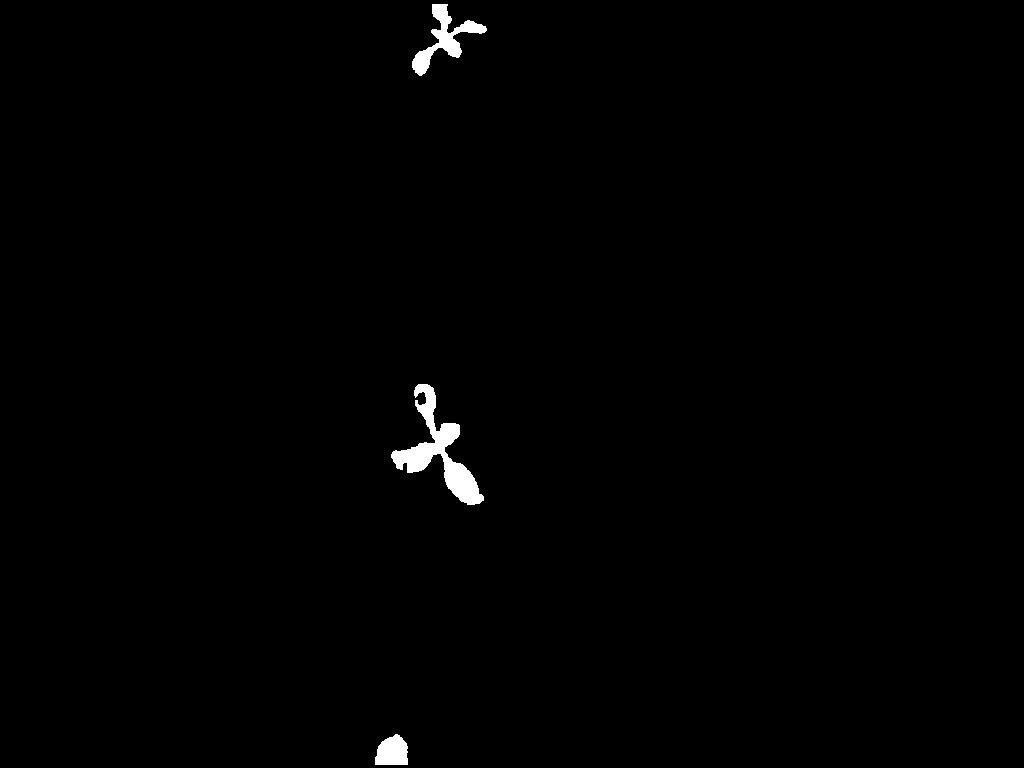

In [7]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps, Image

img = Image.open(image_[-1])
img = img.resize((896,896))
display(img)
img = PIL.ImageOps.autocontrast(load_img(mask_id[-1]))
display(img)

**Define data loader**

In [8]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

class SugarBeets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
    
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=(896,896))
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = np.array(load_img(path, target_size=self.img_size, color_mode="grayscale"))
            img = np.expand_dims(img, 2)
            img[np.where(img == 39)] = 1
            img[np.where(img == 78)] = 2
            y[j] = img
        return x,y

**Initialize training and validation data**

In [9]:
train_gen = SugarBeets(2, (896, 896), image_, mask_id)
val_gen = SugarBeets(2, (896, 896), image_V, mask_V)
test_gen = SugarBeets(2, (896,896), image_T, mask_T)

In [10]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


**Define IoU metric**

In [ ]:
from keras import backend as K
from tensorflow.keras.metrics import MeanIoU
m = MeanIoU(num_classes=3)
def iou_coeff(y_true, y_pred):
    y_true = float(y_true)
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = float(K.reshape(y_pred, (2,896,896,1)))
    m.update_state(y_true, y_pred)
    return m.result()

def iou_coef_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

**Define Model**

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### First half of network: Encoder


    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model



**Train model**

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import MeanIoU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)
model=get_model((896, 896), 3)
model.summary()
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=[iou_coeff])

model.fit(train_gen, validation_data=val_gen,epochs=40)

**Visualize predictions**

In [ ]:
#val_preds = model.predict(test_gen) 
def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1).astype('float32')
    img_size = (1024, 768)
    mask = cv2.resize(mask, img_size)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
i = 2

# Display input image
display(Image(filename=image_T[i]))
# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(mask_T[i]))
display(img)
# Display predicted mask
display_mask(i)  

**Load model**

In [ ]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
test_img = np.array(load_img(image_T[1], target_size=(896,896)))
model = tf.keras.models.load_model('/kaggle/working/model', custom_objects = {"iou_coeff": iou_coeff})
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=[iou_coeff])

**Compute F1 score, weed IoU and Crop IoU**

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
pred = model.predict(test_gen)

f1 = 0

weed_iou = 0
weed_precision = 0
weed_recall = 0
weed_dice = 0

crop_iou = 0
crop_precision = 0
crop_recall = 0
crop_dice = 0

background_iou = 0
background_precision = 0
background_recall = 0
background_dice = 0

In [ ]:
def labelIoU(pred, label, mask, mask_val):
    label_pred = np.zeros([768, 1024])
    label_pred[np.where(pred == label)] = 1
    label_pred = np.reshape(label_pred, (1*768*1024*1, 1))
    label_mask = np.zeros([768, 1024])
    label_mask[np.where(mask == mask_val)] = 1
    label_mask = np.reshape(label_mask, (1*768*1024*1, 1))
    if np.array_equal(label_pred, label_mask):
        return 1
    tn, fp, fn, tp = confusion_matrix(label_mask, label_pred).ravel()
    return (tp / (tp + fn + fp))

In [ ]:
for i in range(len(image_T)):
    pred_i = np.argmax(pred[i], axis=-1)
    pred_i = np.expand_dims(pred_i, axis=-1).astype('float32')
    img_size = (1024, 768)
    pred_i = cv2.resize(pred_i, img_size)
    mask = np.array(load_img(mask_T[i], color_mode="grayscale"))
    # calculate crop IoU
    weed_iou += labelIoU(pred_i, 2, mask, 78)
    # calculate weed IoU
    crop_iou += labelIoU(pred_i, 1, mask, 39)
    # calculate background IoU
    background_iou += labelIoU(pred_i, 0, mask, 0)
    # calculate mean IoU, precision, recall, F1
    mask[np.where(mask==39)] = 1
    mask[np.where(mask==78)] = 2
    pred_i = np.reshape(pred_i, (1*768*1024*1, 1)).astype('uint8')
    mask = np.reshape(mask, (1*768*1024*1, 1)).astype('uint8')
    f1 += f1_score(mask, pred_i, average='micro')
    res = precision_recall_fscore_support(mask, pred_i, average=None, labels=[0, 1, 2], zero_division=1)
    #calculate precision recall and dice score for each class 
    background_precision += res[0][0];
    background_recall += res[1][0];
    background_dice += res[2][0];
    
    crop_precision += res[0][1];
    crop_recall += res[1][1];
    crop_dice += res[2][1];
    
    weed_precision += res[0][2];
    weed_recall += res[1][2];
    weed_dice += res[2][2];
    

In [ ]:
print('Weed IoU: {0}, Weed Precision: {1}, Weed Recall: {2}, Weed Dice score: {3}'.format(weed_iou / 100.0, weed_precision / 100.0, weed_recall / 100.0, weed_dice / 100.0))
print('Crop IoU: {0}, Crop Precision: {1}, Crop Recall: {2}, Crop Dice score: {3}'.format(crop_iou / 100.0, crop_precision / 100.0, crop_recall / 100.0, crop_dice / 100.0))
print('Background IoU: {0}, Background Precision: {1}, Background Recall: {2}, Background Dice score: {3}'.format(background_iou / 100.0, background_precision / 100.0, background_recall / 100.0, background_dice / 100.0))
print('Mean F1 score / Dice coefficient: {0}'.format(f1 / 100))

**Compute mean IoU**

In [ ]:
model.evaluate(test_gen)